# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). Remember that you will have to defend the assignment at the end of the semester.
- **Deadline is March 25**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name:Donia Gharbi**  
**Neptun ID: QNGHNC** 

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [31]:
import os    
import torch 
import torchvision
import pandas as pd  
import numpy as np  
from matplotlib import *
from torch.utils.data import Dataset, random_split, DataLoader  
from PIL import Image  
import torchvision.models as models  
import torchvision.transforms as transforms  
from torchvision import datasets  
import torch.nn.functional as F  
import torch.nn as nn  
from torchvision.utils import make_grid  
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt  
import random
from keras.preprocessing.image import load_img
%matplotlib inline
import datetime

In [32]:
import warnings
warnings.filterwarnings("ignore") 

In [33]:
# hyperparameters
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [34]:
DEVICE = 'coda:0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [35]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42

## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the dataset


In [36]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip -d PetImages

--2022-03-27 14:16:38--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 2.21.40.213, 2a02:26f0:6d00:688::e59, 2a02:26f0:6d00:6bf::e59
Connecting to download.microsoft.com (download.microsoft.com)|2.21.40.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip.2’

kagglecatsanddogs_3 100%[===================>] 786.68M  44.0MB/s    in 13s     

2022-03-27 14:16:52 (58.4 MB/s) - ‘kagglecatsanddogs_3367a.zip.2’ saved [824894548/824894548]

Archive:  kagglecatsanddogs_3367a.zip
replace PetImages/PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [37]:
!rm ./PetImages/PetImages/Dog/11702.jpg
!rm ./PetImages/PetImages/Cat/666.jpg

rm: cannot remove './PetImages/PetImages/Dog/11702.jpg': No such file or directory
rm: cannot remove './PetImages/PetImages/Cat/666.jpg': No such file or directory


#### Pre-processing the dataset

In [38]:
data_dir = "./PetImages/PetImages"

mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transformed = transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

whole_data = datasets.ImageFolder(data_dir,transform=transformed)

In [39]:
len(whole_data)

24998

In [40]:
whole_data.classes

['Cat', 'Dog']

#### Splitting the dataset

In [41]:
train_dataset, rest_dataset_1 = torch.utils.data.random_split(whole_data, [8000, 16998])
train_dataset_2, rest_dataset_2 = torch.utils.data.random_split(train_dataset, [4000, 4000])
valid_dataset, test_dataset = torch.utils.data.random_split(rest_dataset_2, [2400, 1600])

In [42]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

#### Show some images and labels of your dataset

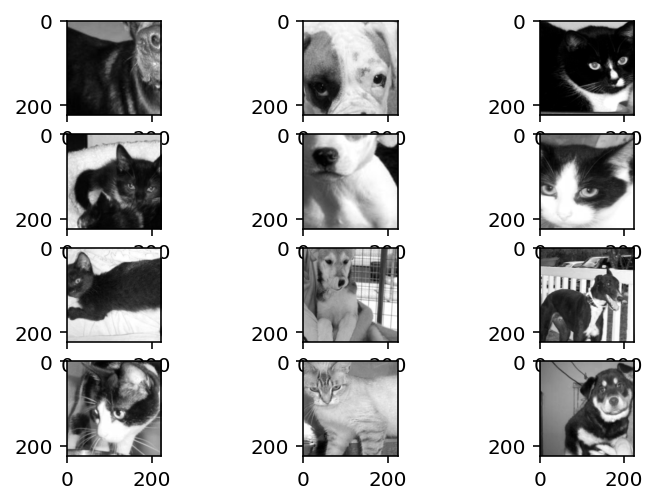

In [56]:
examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the architecture

In [45]:
model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [46]:
model.classifier[6] = nn.Linear(4096,2)

In [47]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Define your optimizer and loss function

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


#### Train your network

#### Show results (accuracy and loss) on training and validation sets

In [49]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=3, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = './cifar_best_net.pth'

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.best_model)
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [50]:
early_stopping = EarlyStopping()

In [51]:
def evaluate():
  running_loss = 0.0
  
  with torch.no_grad():
    for i, data in enumerate(valid_loader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
  val_loss = running_loss / len(valid_loader)
  print('val loss: %.3f' % (val_loss))
  return val_loss


def eval_acc(train=False):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      loader = train_loader if train else valid_loader
      for data in loader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  
  print('Accuracy of the network on the %s images: %d %%' % (
      'train' if train else 'test', 100 * correct / total))

In [52]:
model= model.to(device)
def train():
  NUM_EPOCHS = 15
  for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
      print(f'Epoch {epoch+1}:')
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          #inputs, labels = data
          inputs, labels = data[0].to(device), data[1].to(device) #set for GPU if available

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 250 == 0 and i!= 0: 
              print(f'Iteration {i}, loss = {(running_loss / 250):.3f}')
              running_loss = 0.0

      val_loss = evaluate()
      eval_acc()
      early_stopping(val_loss)
      if early_stopping.early_stop:
          break
  print('Finished Training')

In [53]:
train()

Epoch 1:
val loss: 0.184
Accuracy of the network on the test images: 92 %
Epoch 2:
val loss: 0.202
Accuracy of the network on the test images: 90 %
INFO: Early stopping counter 1 of 3
Epoch 3:
val loss: 0.189
Accuracy of the network on the test images: 91 %
INFO: Early stopping counter 2 of 3
Epoch 4:
val loss: 0.193
Accuracy of the network on the test images: 91 %
INFO: Early stopping counter 3 of 3
INFO: Early stopping
Finished Training


## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

In [54]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        probs = model(images)
        _, predicted = torch.max(probs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 91.8125 %


#### Show some predictions

GroundTruth:  Cat  
Predicted:  Cat  


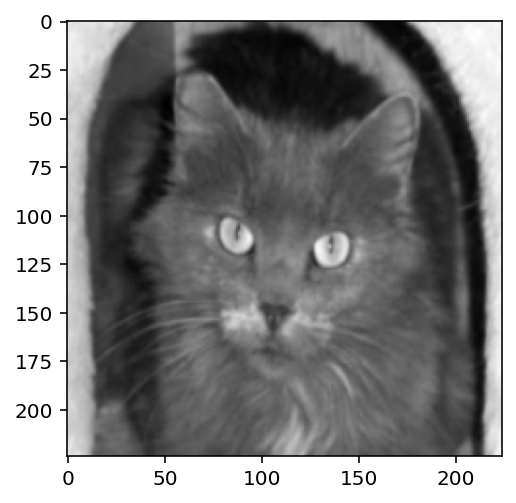

GroundTruth:  Cat  
Predicted:  Cat  


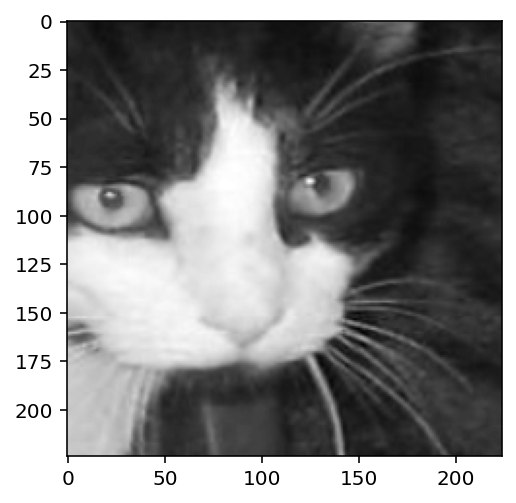

GroundTruth:  Dog  
Predicted:  Cat  


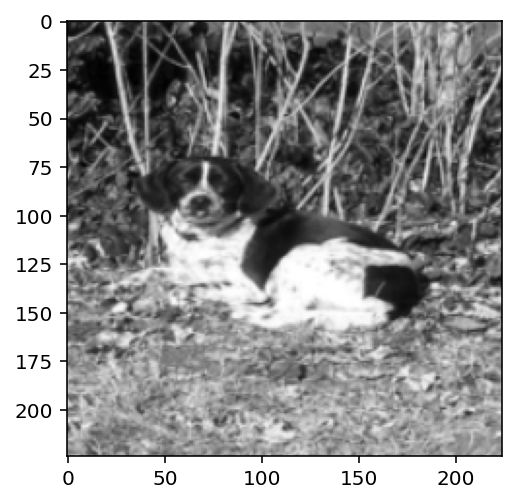

GroundTruth:  Cat  
Predicted:  Dog  


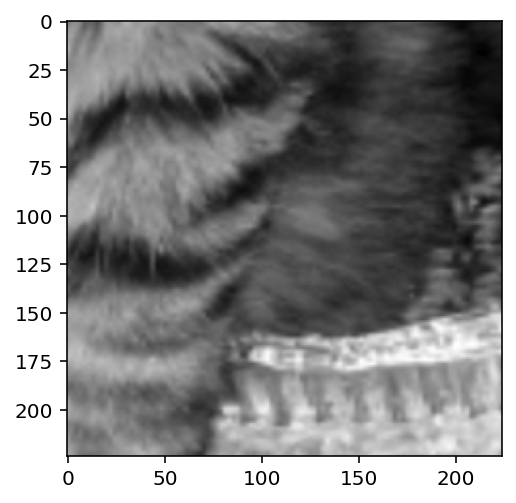

GroundTruth:  Dog  
Predicted:  Dog  


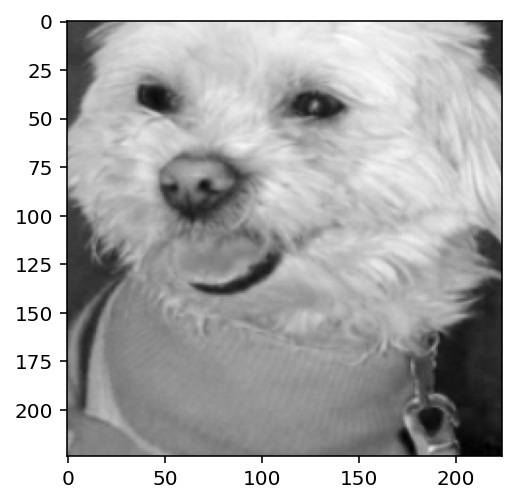

In [63]:
dataiter = iter(test_loader)
example_data, example_targets = examples.next()
classes = ("Cat","Dog")
outputs = model(images)
_, predicted = torch.max(outputs, 1)


# print images
for i in range(5):
  img = torchvision.utils.make_grid(example_data).numpy()
  plt.imshow(example_data[i][0], cmap='gray')
  print('GroundTruth: ', f'{classes[example_targets[i]]:5s}' )
  print('Predicted: ', f'{classes[predicted[i]]:5s}')
  plt.show()
#imshow(img)

#### Answer the questions


1.   How good are your results? 

> Despite the use of a sample of the dataset due to computing problems, the accuracy of the network on the test images is a little over 90%. Which is already good enough of a result and it could possibly be improved if the whole dataset is used.


2.   Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

> We can see through the results in the training phase , that the validation loss is not stable : it keeps increasing and decreasing. which is why we used Early stopping to avoid overfitting.

> ***Early stopping*** : is a function that stops the training when the loss does not improve after certain EPOCHS.












